# Lab Six -  Convolutional Network Architectures
Amory Weinzierl, Fidelia Nawar, and Hayden Center

In this lab, you will select a prediction task to perform on your dataset, evaluate a deep learning architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (<b>one per team</b>) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

<b>Dataset Selection</b>

Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

The dataset we chose can be found at: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

## Preparation (3 pts)

- [<b>1.5 points</b>] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a <b>detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate</b>b for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [<b>1.5 points</b>] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). <b>Explain why your chosen method is appropriate or use more than one method as appropriate</b>. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [1]:
# Importing packages and reading in dataset
import numpy as np
import pandas as pd

print('Pandas:', pd.__version__)
print('Numpy:',  np.__version__)

Pandas: 1.1.3
Numpy: 1.19.2


In [2]:
#source: https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#source: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
from pathlib import Path

#directory name
train_path = './Coronahack-Chest-XRay-Dataset/train/'
test_path = './Coronahack-Chest-XRay-Dataset/test/'

metadata = pd.read_csv('./Chest_xray_Corona_Metadata.csv')

image_data_train = metadata[metadata['Dataset_type'] != "TEST"]
image_data_target = metadata[metadata['Dataset_type'] == "TEST"]

labels = list(metadata.Label)

%time

train_images = image_data_train['X_ray_image_name'].copy(deep=True)
target_images = image_data_target['X_ray_image_name'].copy(deep=True)

imagesToDisplay = []
X = []
y = []
h, w = 100, 100

for img in train_images:
    
    img_arr = np.asarray(Image.open(train_path + img).convert('L').resize((h,w)))
    
    # Image data in correct dimensions (100 x 100)
    imagesToDisplay.append(img_arr)
    
    X.append(img_arr)

for img in target_images:
    img_arr = np.asarray(Image.open(test_path + img).convert('L').resize((h,w)))
    y.append(img_arr)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.05 µs


In [3]:
X = np.array(X).astype(np.float32)/16.0 - 0.5
y = np.array(y).astype(np.int32)

print(X.shape, type(X))
print(y.shape, type(y))

(5286, 100, 100) <class 'numpy.ndarray'>
(624, 100, 100) <class 'numpy.ndarray'>


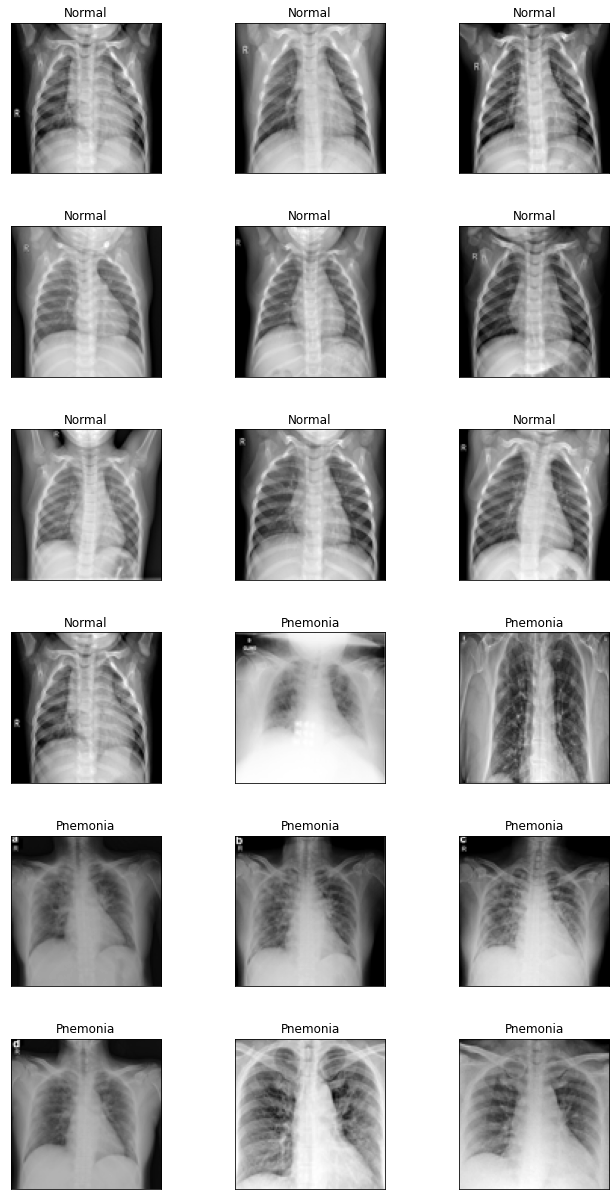

In [4]:
#plot images
def plot_gallery(images, titles, h, w, n_row=3, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(n_col * n_col, 6 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    #normal scans tended towards front
    for i in range(n_row * n_col):
        plt.subplot(n_row * 2, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    #pnemonia scans toward back so we pulled some from the back 
    #for demonstration purposes
    for j in range(n_row * n_col):
        plt.subplot(n_row * 2, n_col, n_row * n_col + j + 1)
        plt.imshow(images[-1*j], cmap=plt.cm.gray)
        plt.title(titles[-1*j], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(imagesToDisplay, labels, 100, 100)

#### Evaluation Metric
The evaluation metric we are using for our model is recall. This metric is the ratio of correctly predicted positive observations to all observations of the class. More specifically, Recall = True Positives / (True Positives + False Negatives).

The metric emphasizes minimizing false negatives, which is applicable to evaluate our solution because we want to minimize the amount of undetected pneumonia lungs (hence why we need a low false negative rate). Having a low false negative rate is important in this situation because a diagnosis of a "Normal" lung condition when it is in fact penumonia is detrimental and possibly fatal to the patient. On the same token, it's necessary that healthy lungs are not misclassified as pneumonia because that would create unnecessary issues for a healthy patient. Because of this, we chose to use recall, implemented below, to evaluate our CNN solution.


In [5]:
from keras import backend as K

#recall implementation from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

#### Dividing Data

We are using 10-fold Cross Validation in order to split up the data into training and test sets. We chose to use this method because almost 3/4 of our the lungs in our dataset are labeled as having pneumonia, whereas only 1/4 is labeled as healthy. Thus, if we did a random split/shuffle, there may be disproportionate amounts of pneumonia classification in the training variables, which would make the classification for the testing data less accurate. With 
Stratified 10-fold cross validation, we can make a more effective model and also help with generalizing. It allows us to select training and testing sets while also decreasing overall variance because of the 10 folds, which will fit each CNN on each fold. After fitting the model on 10 folds, we can evaluable it on a test set created using an 80-20 split. This would be a realistic measuring of a real-world application of the algorithm because with smaller test sets, there is higher variance. Stratified cross validation reduces this variance by averaging over k different partitions, so the performance estimate is less sensitive to the partitioning of the data. We also chose 10 folds because this value has been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance. 

In [6]:
#This block is essentially not using the separated test and target folders from 
# ./Coronahack-Chest-XRay-Dataset/ directory. I'm simply training/splitting on the metadata.csv

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras.utils import to_categorical
import tensorflow as tf

tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible

data = pd.read_csv('Chest_xray_Corona_Metadata.csv')

#shuffle data
data = data.sample(frac=1)

# Define features and target
X_ = data.drop("Label", axis=1)
y_ = data["Label"]

#perform Stratified 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True).split(X_, y_)

# Split it into train / test subset
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.20, random_state=0)

X_train_df = pd.DataFrame(X_train, columns= data.columns)
X_test_df = pd.DataFrame(X_test, columns= data.columns)

## Modeling (6 pts)

- [<b>1.5 points</b>]  Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
- [<b>2 points</b>] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
- [<b>1.5 points</b>] Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
- [<b>1 points</b>] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work (1 pt)

- You have free reign to provide additional analyses. 
- One idea (<b>required for 7000 level students</b>): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance. 